Meeting notes:
- Better to do cleaning in code? Bc we need city names...

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv('numerical_data.csv')

In [4]:
# Preprocess data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_imputed)

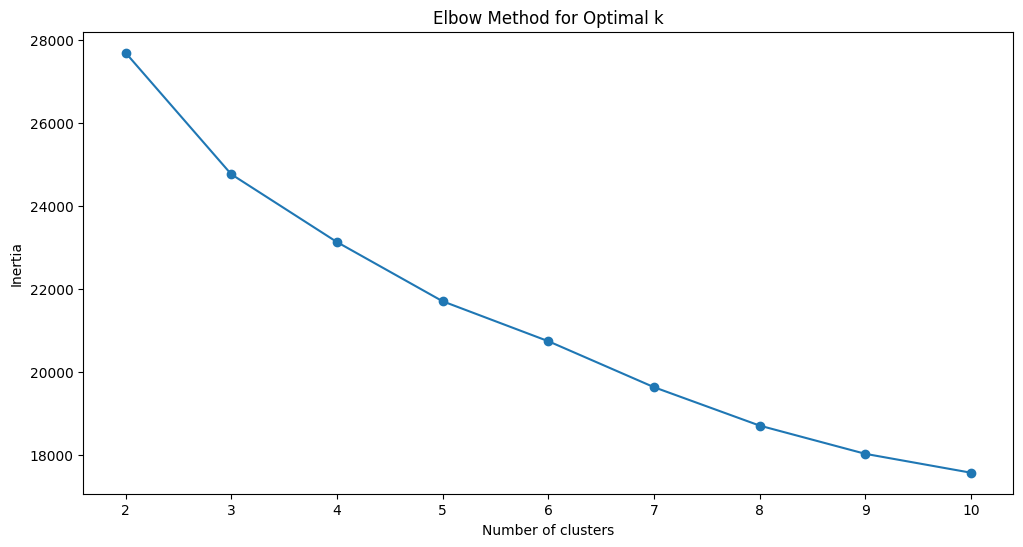

In [5]:
# Finding the optimal number of clusters using the elbow method
inertia = []
silhouette_coefficients = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(df_normalized)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_coefficients.append(silhouette_score(df_normalized, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_normalized, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_normalized, labels))

plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

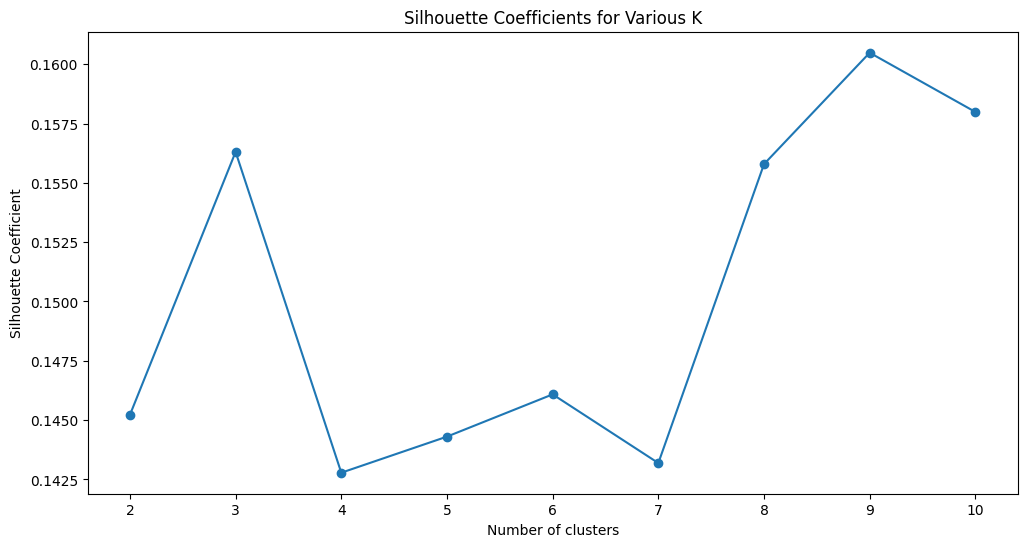

In [6]:
# Silhouette (higher = better)
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficients for Various K')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

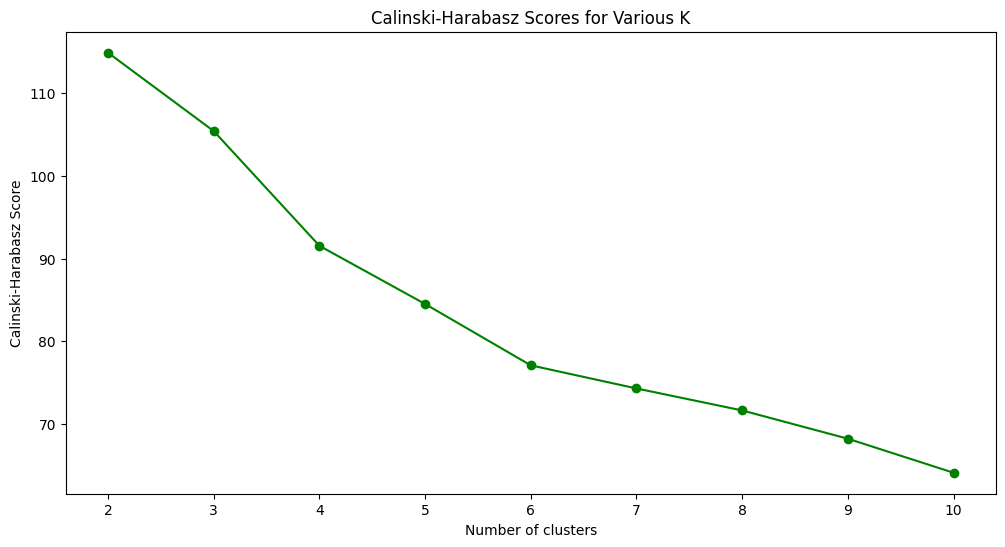

In [7]:
# Plotting Calinski-Harabasz Scores (higher = better)
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), calinski_harabasz_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Scores for Various K')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

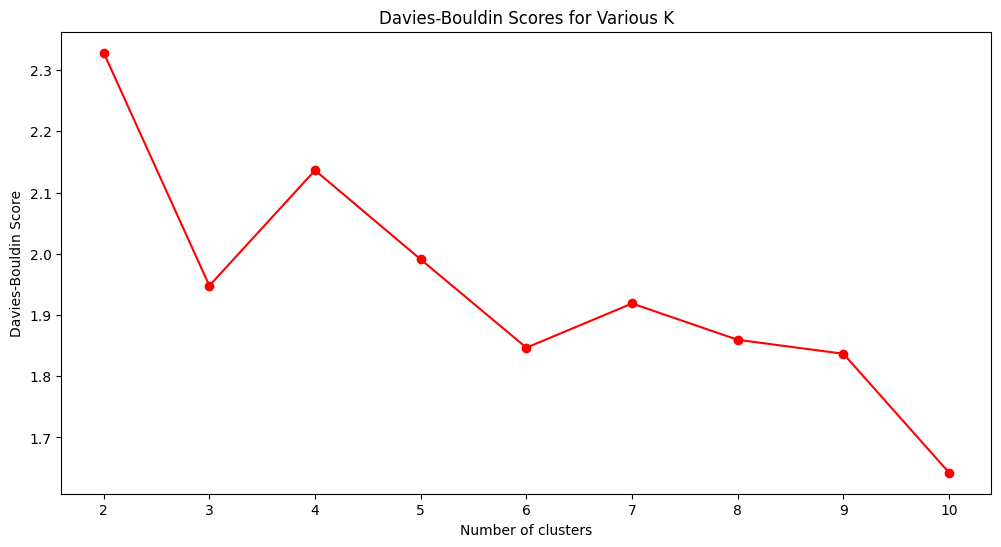

In [8]:
# Plotting Davies-Bouldin Scores (lower = better)
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), davies_bouldin_scores, marker='o', color='red')
plt.title('Davies-Bouldin Scores for Various K')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

In [9]:
n_clusters = 3

kmeans_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
df['cluster'] = kmeans_final.fit_predict(df_normalized)

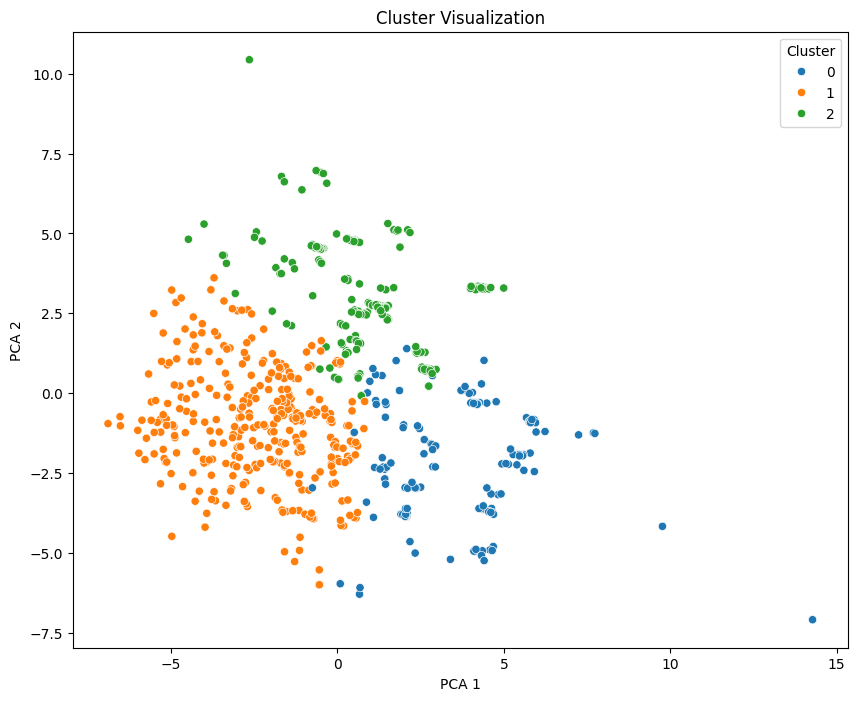

In [10]:
# Reducing dimensions for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Plotting the clusters along the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', legend="full")
plt.title('Cluster Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

In [11]:
# def recommend_similar_cities(city_name, df):
#     cluster = df.loc[df['city'] == city_name, 'cluster'].iloc[0]

#     recommended_cities = df[df['cluster'] == cluster][['city', 'state_name_x']].drop_duplicates()

#     recommended_cities = recommended_cities[recommended_cities['city'] != city_name]

#     return recommended_cities

# # Example usage
# city_name = "Boston"
# recommendations = recommend_similar_cities(city_name, df)
# print(recommendations.head())

def recommend_closest_neighbors(ID_number, df, num_neighbors=5):
    df = df.set_index('Unnamed: 0')

    cluster = df.loc[ID_number, 'cluster']

    same_cluster_entities = df[df['cluster'] == cluster].drop(index=ID_number)

    distances = pairwise_distances(same_cluster_entities.drop('cluster', axis=1),
                                   df.loc[[ID_number]].drop('cluster', axis=1),
                                   metric='euclidean').flatten()

    closest_indices = np.argsort(distances)[:num_neighbors]

    closest_entities = same_cluster_entities.iloc[closest_indices].index.tolist()
    return closest_entities

# Example usage
ID_number = 126 # Boston
closest_neighbors = recommend_closest_neighbors(ID_number, df)
print(closest_neighbors)

[125, 143, 112, 155, 254]


Boston: Denver, Balimore, San Francisco, Atlanta, Seattle

New York: Chicago, Philadelphia, San Jose, San Francisco, Seattle

Omaha: Wichita, Virginia Beach, Tulsa, Aurora, Colorado Springs

In [12]:
# Print cluster evaluation scores
print(f'Final SSE (Inertia): {kmeans_final.inertia_}')
silhouette_avg = silhouette_score(df_normalized, kmeans_final.labels_)
print(f'Silhouette Score: {silhouette_avg}')
# higher the better
calinski_harabasz = calinski_harabasz_score(df_normalized, kmeans_final.labels_)
print(f'Calinski-Harabasz Score: {calinski_harabasz}')
# should be less than 1
davies_bouldin = davies_bouldin_score(df_normalized, kmeans_final.labels_)
print(f'Davies-Bouldin Score: {davies_bouldin}')

Final SSE (Inertia): 24766.332148879555
Silhouette Score: 0.15630373864085012
Calinski-Harabasz Score: 105.40131919207609
Davies-Bouldin Score: 1.9478934127483027


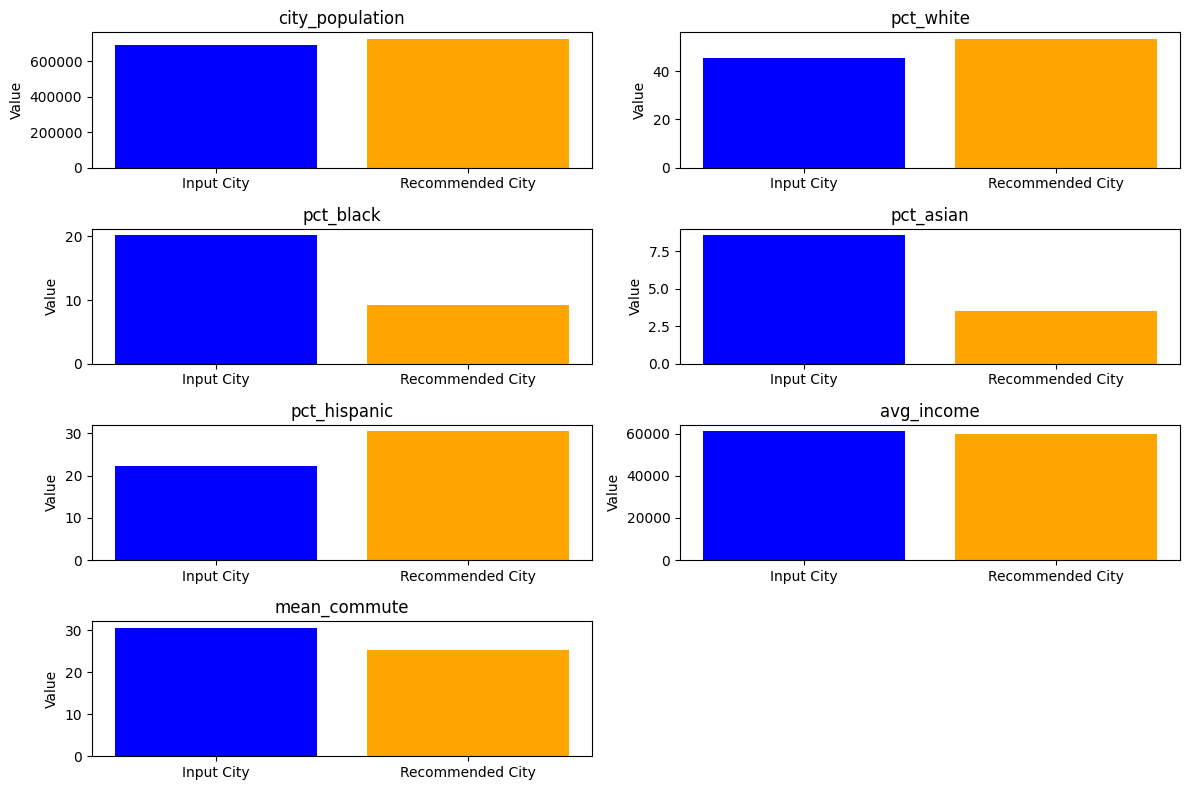

In [13]:
def compare_cities(input_city, recommended_city, df):
    features = ['city_population', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
                'avg_income', 'mean_commute'] # Pick features

    input_city_data = df[df['Unnamed: 0'] == input_city][features].squeeze()
    recommended_city_data = df[df['Unnamed: 0'] == recommended_city][features].squeeze()

    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(features, start=1):
        plt.subplot(4, 2, i)
        plt.bar(['Input City', 'Recommended City'], [input_city_data[feature], recommended_city_data[feature]], color=['blue', 'orange'])
        plt.title(feature)
        plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

# Example usage
input_city = 126 # Boston
recommended_city = closest_neighbors[0] # First recommended city
compare_cities(input_city, recommended_city, df)